In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

%matplotlib inline
sns.set(style="white")

In [2]:
# get market info for bitcoin from the start of Aug 7, 2015 to the current day
start_date = "20150807"
start_date_ = '2015-08-07'

bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start="+start_date+"&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
# bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-04-05,6848.65,6933.82,6644.80,6811.47,5639320000,116142000000
1,2018-04-04,7456.41,7469.88,6803.88,6853.84,4936000000,126434000000
2,2018-04-03,7102.26,7530.94,7072.49,7456.11,5499700000,120415000000
3,2018-04-02,6844.86,7135.47,6816.58,7083.80,4333440000,116037000000
4,2018-04-01,7003.06,7060.95,6526.87,6844.23,4532100000,118705000000


In [3]:
bitcoin_market_info.describe()

,Open,High,Low,Close,Volume,Market Cap
count,973.000000,973.000000,973.000000,973.000000,9.730000e+02,9.730000e+02
mean,2770.067492,2875.688386,2651.223186,2776.331316,1.821654e+09,4.595277e+10
std,3966.947608,4148.482664,3739.339719,3967.757601,3.744955e+09,6.681140e+10
min,210.070000,226.320000,199.570000,210.500000,1.271260e+07,3.053250e+09
25%,439.350000,447.560000,434.410000,441.390000,6.070350e+07,6.689200e+09
50%,768.490000,774.700000,758.720000,769.730000,1.315700e+08,1.231250e+10
75%,2953.220000,3290.010000,2874.830000,3154.950000,1.489450e+09,4.839120e+10
max,19475.800000,20089.000000,18974.100000,19497.400000,2.384090e+10,3.261410e+11


In [4]:
# get market info for ethereum from the start of Aug 7, 2015  to the current day
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start="+start_date+"&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# look at the first few rows
eth_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-04-05,379.95,387.72,369.82,383.23,1210680000,37470200000
1,2018-04-04,416.49,417.47,375.31,380.54,1287730000,41065100000
2,2018-04-03,387.31,418.97,383.53,416.89,1363400000,38180800000
3,2018-04-02,379.70,395.17,377.59,386.43,1102260000,37422500000
4,2018-04-01,397.25,400.53,363.81,379.61,1256930000,39144700000


In [5]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

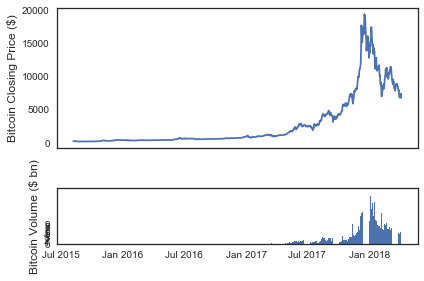

In [6]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[5, 2]})
ax1.set_ylabel('Bitcoin Closing Price ($)',fontsize=12)
ax2.set_ylabel('Bitcoin Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['bt_Open'])
ax2.bar(bitcoin_market_info['Date'].astype(datetime.datetime).values, bitcoin_market_info['bt_Volume'].values)
fig.tight_layout()
plt.show()

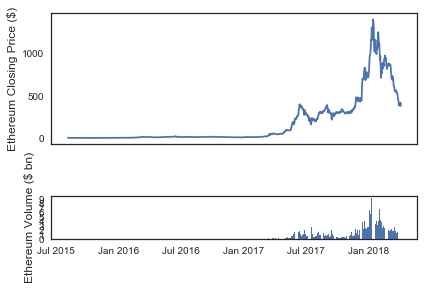

In [7]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
ax1.set_ylabel('Ethereum Closing Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(eth_market_info['Date'].astype(datetime.datetime),eth_market_info['eth_Open'])
ax2.bar(eth_market_info['Date'].astype(datetime.datetime).values, eth_market_info['eth_Volume'].values)
fig.tight_layout()
plt.show()

In [8]:
market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>=start_date_]

for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
0,2018-04-05,6848.65,6933.82,6644.80,6811.47,5639320000,116142000000,379.95,387.72,369.82,383.23,1210680000,37470200000,-0.005429,0.008633
1,2018-04-04,7456.41,7469.88,6803.88,6853.84,4936000000,126434000000,416.49,417.47,375.31,380.54,1287730000,41065100000,-0.080812,-0.086317
2,2018-04-03,7102.26,7530.94,7072.49,7456.11,5499700000,120415000000,387.31,418.97,383.53,416.89,1363400000,38180800000,0.049822,0.076373
3,2018-04-02,6844.86,7135.47,6816.58,7083.80,4333440000,116037000000,379.70,395.17,377.59,386.43,1102260000,37422500000,0.034908,0.017725
4,2018-04-01,7003.06,7060.95,6526.87,6844.23,4532100000,118705000000,397.25,400.53,363.81,379.61,1256930000,39144700000,-0.022680,-0.044405


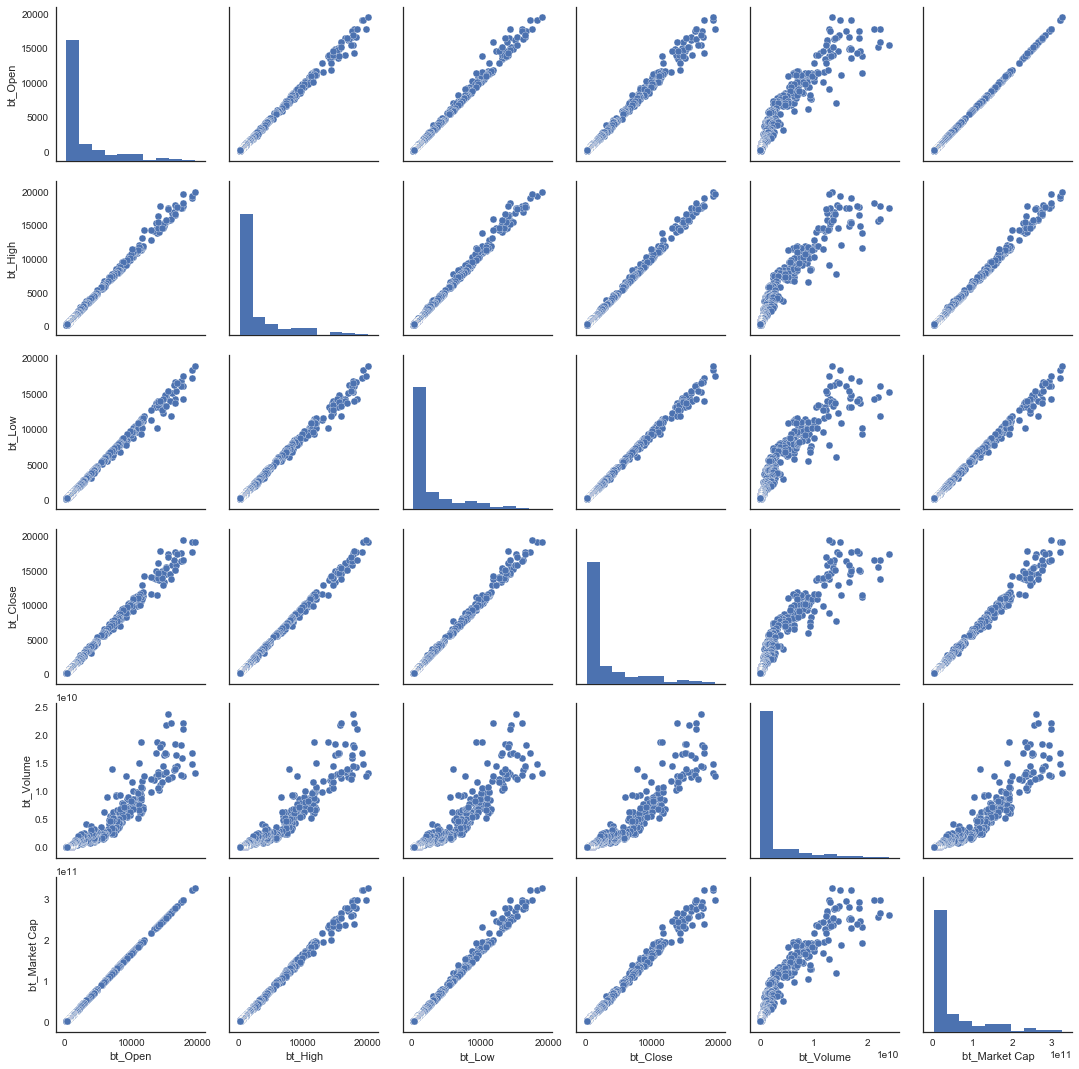

In [9]:
sns.pairplot(bitcoin_market_info)

In [10]:
# Open and Market Cap are directly related. So, one of these could be dropped

In [11]:
print(eth_market_info.columns)

Index(['Date', 'eth_Open', 'eth_High', 'eth_Low', 'eth_Close', 'eth_Volume',
       'eth_Market Cap'],
      dtype='object')


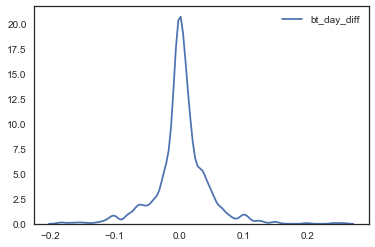

In [12]:
sns.kdeplot(market_info['bt_day_diff'])

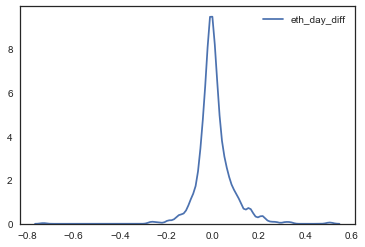

In [13]:
sns.kdeplot(market_info['eth_day_diff'])

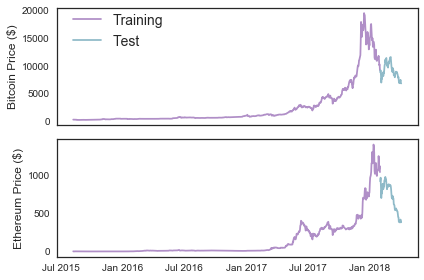

In [14]:
split_date = '2018-02-02'
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['bt_Close'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['bt_Close'], 
         color='#8FBAC8', label='Test')
ax2.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['eth_Close'], 
         color='#B08FC7')
ax2.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['eth_Close'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
# fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
#              200, 260, zorder=3,alpha=.5)
# fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
#              350, 40, zorder=3,alpha=.5)
plt.show()

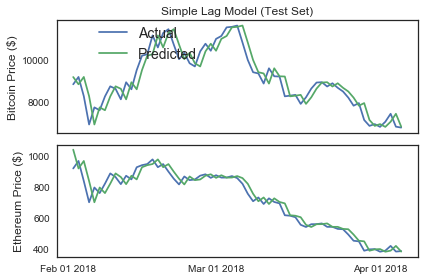

In [15]:
# Persistent model
# trivial Persistence model: P_t = P_(t-1)
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['bt_Close'][1:].values, label='Predicted')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.set_title('Simple Lag Model (Test Set)')
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['eth_Close'][1:].values, label='Predicted')
fig.tight_layout()
plt.show()

In [16]:
test_data = market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d')]

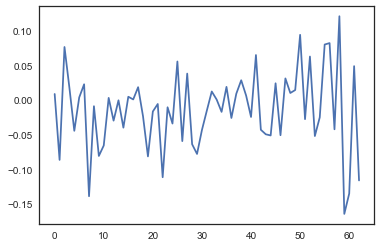

In [17]:
plt.plot(test_data['eth_day_diff'])

In [18]:
actual_bitcoin = market_info[market_info['Date']>= split_date]['bt_day_diff'].values
print(len(actual_bitcoin))
pred_bitcoin = market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['bt_day_diff'][1:].values
print(len(pred_bitcoin))

# print(actual_bitcoin)
# print(pred_bitcoin)
# print(np.absolute((actual_bitcoin - pred_bitcoin)))

# NOTE: ****** Baseline: no change from previous day => pred_bitcoin = 0 (percent change) for persistence model
mae = np.mean(np.absolute((actual_bitcoin)))
mse = np.mean(np.square((actual_bitcoin)))

# mae = np.mean(np.absolute((actual_bitcoin - pred_bitcoin)))

print(mae)
print(mse)

63
63
0.04458678612819951
0.0030759265639413265


In [19]:
# LSTM begins

# New features
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'close_off_high': lambda x: 1-2*(x[coins+'High']-x[coins+'Close'])/(x[coins+'High']-x[coins+'Low']),
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

In [20]:
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff,bt_close_off_high,bt_volatility,eth_close_off_high,eth_volatility
0,2018-04-05,6848.65,6933.82,6644.80,6811.47,5639320000,116142000000,379.95,387.72,369.82,383.23,1210680000,37470200000,-0.005429,0.008633,0.153346,0.042201,0.498324,0.047111
1,2018-04-04,7456.41,7469.88,6803.88,6853.84,4936000000,126434000000,416.49,417.47,375.31,380.54,1287730000,41065100000,-0.080812,-0.086317,-0.849970,0.089319,-0.751898,0.101227
2,2018-04-03,7102.26,7530.94,7072.49,7456.11,5499700000,120415000000,387.31,418.97,383.53,416.89,1363400000,38180800000,0.049822,0.076373,0.673552,0.064550,0.882619,0.091503
3,2018-04-02,6844.86,7135.47,6816.58,7083.80,4333440000,116037000000,379.70,395.17,377.59,386.43,1102260000,37422500000,0.034908,0.017725,0.675938,0.046588,0.005688,0.046300
4,2018-04-01,7003.06,7060.95,6526.87,6844.23,4532100000,118705000000,397.25,400.53,363.81,379.61,1256930000,39144700000,-0.022680,-0.044405,0.188436,0.076264,-0.139434,0.092435


In [21]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_', 'eth_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility', 'day_diff']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,bt_day_diff,eth_Close,eth_Volume,eth_close_off_high,eth_volatility,eth_day_diff
972,2015-08-07,279.58,42484800,0.597015,0.014422,0.003014,2.770000,164329,-0.509804,0.360424,-0.021201
971,2015-08-08,261.00,58533000,-0.969823,0.068707,-0.066991,0.753325,674188,-0.962979,0.747410,-0.729991
970,2015-08-09,265.08,23789600,0.411945,0.025008,0.015165,0.701897,532170,-0.419789,0.354916,-0.006003
969,2015-08-10,264.47,20979400,-0.155756,0.016687,-0.003804,0.708448,405283,0.541175,0.130685,-0.007761
968,2015-08-11,270.39,25433900,1.000000,0.023833,0.022887,1.070000,1463100,0.742911,0.659192,0.511114


In [22]:
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [23]:
window_len = 25 # 20 10
norm_cols = [coin+metric for coin in ['bt_', 'eth_'] for metric in ['Close','Volume']]

In [41]:
target = 'eth_day_diff'

In [42]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)

# model output is next price normalised to 10th previous closing price
# LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1
LSTM_training_outputs = training_set[target][window_len:].values

In [43]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
# LSTM_test_outputs = (test_set['eth_Close'][window_len:].values/test_set['eth_Close'][:-window_len].values)-1
LSTM_test_outputs = test_set[target][window_len:].values

In [44]:
print(len(training_set))
print(len(test_set))

910
63


In [45]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [46]:
type(LSTM_test_inputs)

numpy.ndarray

In [47]:
import keras
print (keras.__version__)

2.1.5


In [48]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.5, loss="mse", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(100, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(25, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(10))
    model.add(Dropout(dropout))
    
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [49]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 1000)

# note: bt_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=15, batch_size=1, verbose=2, shuffle=True)

Epoch 1/15
 - 57s - loss: 0.0096
Epoch 2/15
 - 51s - loss: 0.0063
Epoch 3/15
 - 50s - loss: 0.0055
Epoch 4/15
 - 45s - loss: 0.0057
Epoch 5/15
 - 49s - loss: 0.0054
Epoch 6/15
 - 47s - loss: 0.0052
Epoch 7/15
 - 46s - loss: 0.0053
Epoch 8/15
 - 46s - loss: 0.0052
Epoch 9/15
 - 45s - loss: 0.0051
Epoch 10/15
 - 49s - loss: 0.0052
Epoch 11/15
 - 46s - loss: 0.0051
Epoch 12/15
 - 45s - loss: 0.0052
Epoch 13/15
 - 50s - loss: 0.0051
Epoch 14/15
 - 51s - loss: 0.0051
Epoch 15/15
 - 57s - loss: 0.0051


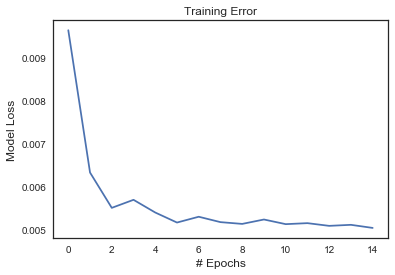

In [50]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(bt_history.epoch, bt_history.history['loss'])
ax1.set_title('Training Error')

if bt_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

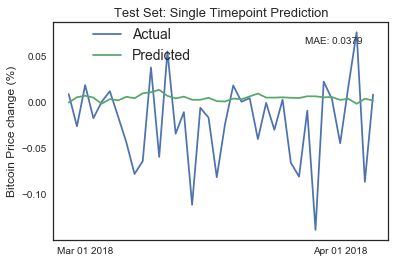

In [51]:
fig, ax1 = plt.subplots(1,1)
LSTM_test_outputs = training_set[target][window_len:].values
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set[target][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         (bt_model.predict(LSTM_test_inputs)), 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs(bt_model.predict(LSTM_test_inputs)-\
            (test_set[target].values[window_len:]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price change (%)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

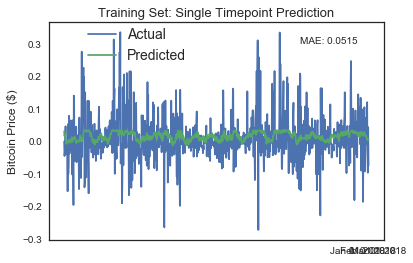

In [52]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set[target][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         (bt_model.predict(LSTM_training_inputs)), 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs(bt_model.predict(LSTM_training_inputs)-\
            (training_set[target].values[window_len:]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Training Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

In [53]:
pred_values = bt_model.predict(LSTM_training_inputs)

In [54]:
max(pred_values)

array([0.03562893], dtype=float32)

In [55]:
min(pred_values)

array([-0.01260514], dtype=float32)

In [56]:
# Notes:
# Include other currencies (ripple, litecoin, bitcoin cash?) - Ideally, pre-cluster 1600+ currencies and find the ones of interest
# Predicting price Vs percent change? Does LSTM make sense for predicting percent-change?
# 
# Window size; # of neurons; # of layers; 
# Split date?